If you use this code, please cite

[Kazuki Nakajima, Takeaki Uno. Inference and Visualization of Community Structure in Attributed Hypergraphs Using Mixed-Membership Stochastic Block Models. Social Network Analysis and Mining. Vol. 15, Article No. 5 (2025).](https://doi.org/10.1007/s13278-025-01440-z)

In [1]:
import time
import numpy as np
import hypergraph, hymmsbm, hycosbm, comm_vis
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
import math
from scipy import stats
import seaborn as sns
import random
from itertools import combinations
from scipy.stats import wilcoxon
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

fontsize = 40
datadir = "./data"

plt.rcParams["font.size"] = fontsize
plt.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in' 
plt.rcParams['xtick.major.width'] = 2.5 
plt.rcParams['xtick.minor.width'] = 1 
plt.rcParams['ytick.major.width'] = 2.5 
plt.rcParams['ytick.minor.width'] = 1 
plt.rcParams['axes.linewidth'] = 2.5 
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.minor.size'] = 12.5
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.minor.size'] = 12.5
plt.rcParams['hatch.linewidth'] = 0.3

random_state = 42

1000 3 2 1 1 0.5
999 2248 2
Numbers of steps [4, 20, 22, 4, 15, 4, 16, 4, 21, 4]


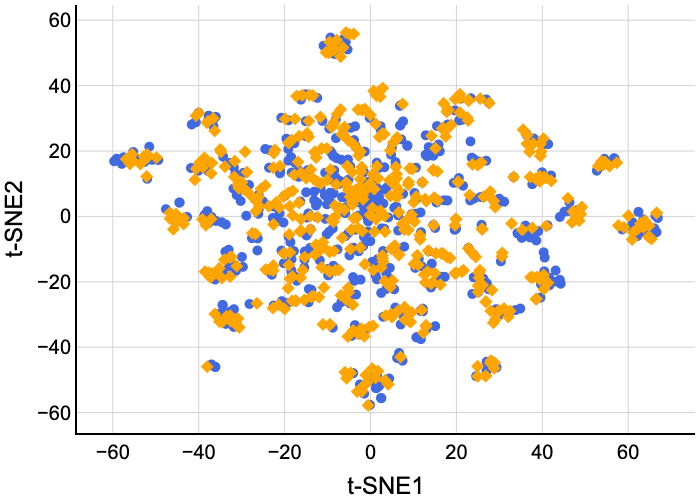

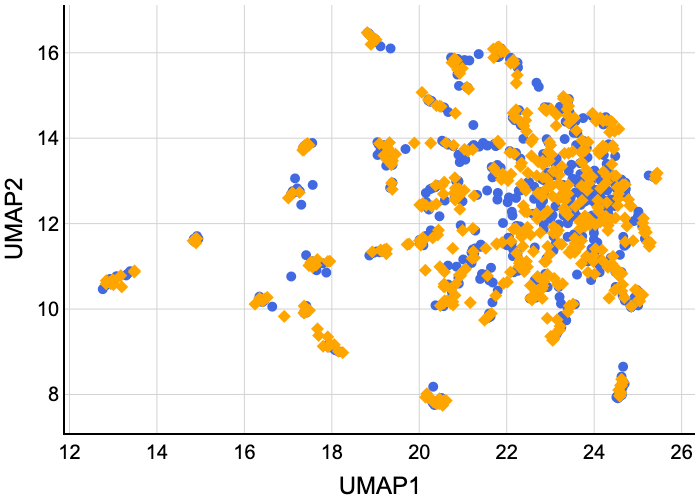

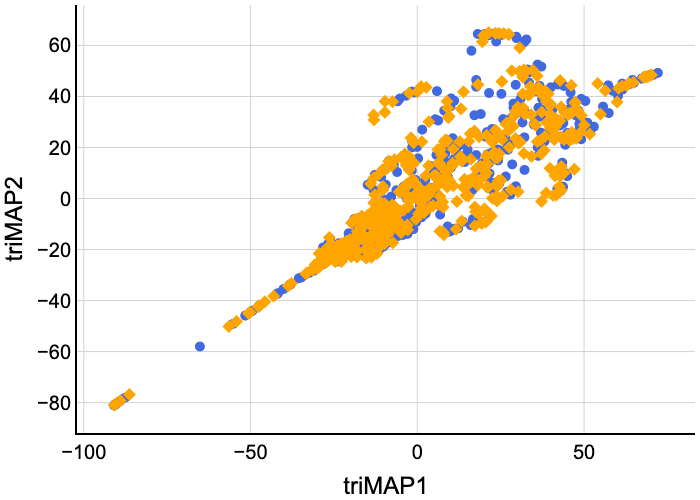

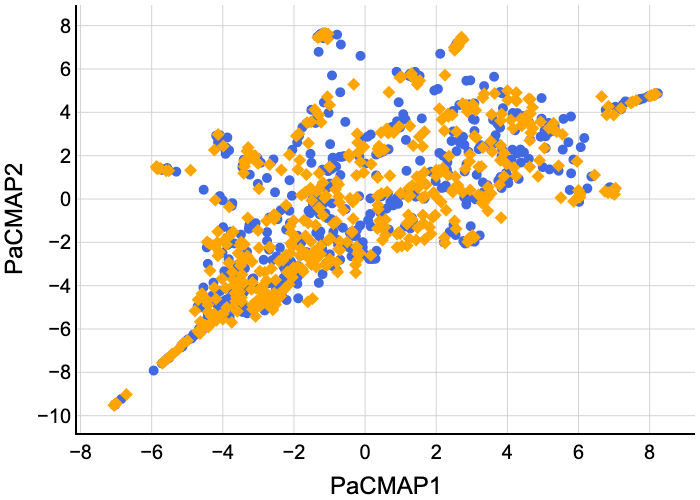

1000 3 2 10 1 0.5
1000 7606 2
Numbers of steps [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


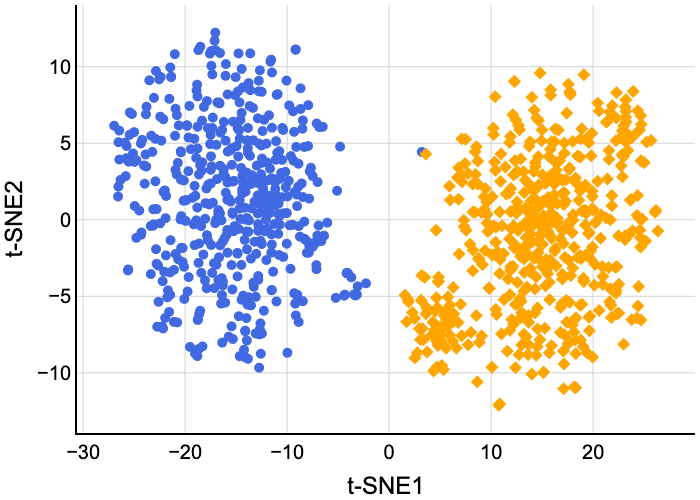

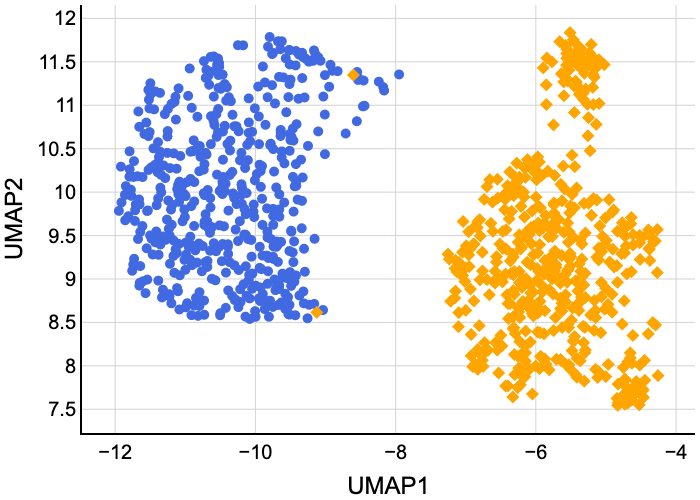

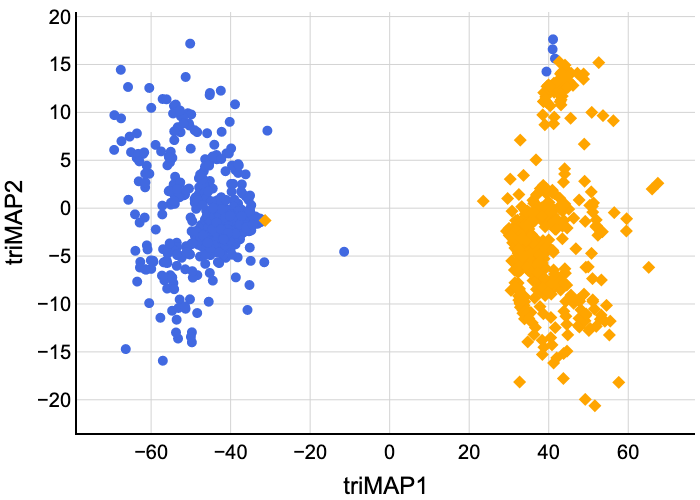

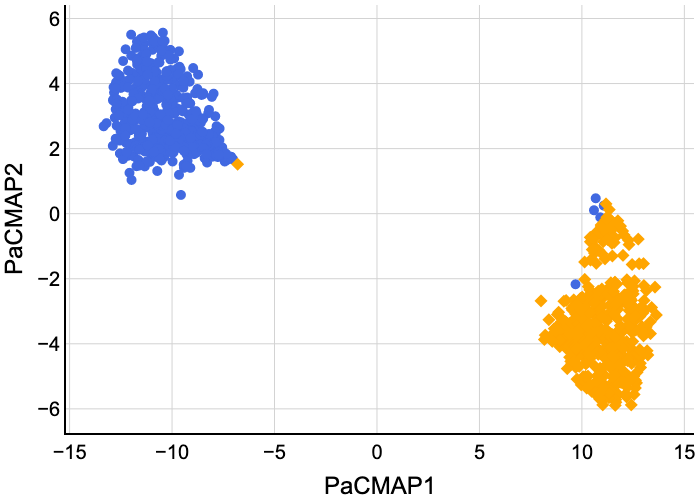

In [2]:
# Fig.2
N = 1000
beta_ = 1
k = 3
K = 2
alpha_lst = [1, 10]
p_att_lst = [0.5]
label_name = ["First community","Second community"]
label_order = [0, 1]

for p_att in p_att_lst:
    for alpha in alpha_lst:
        
        data_name = 'syn_hard_' + str(N) + '_' + str(p_att) + '_' + str(alpha)
        G, community = hypergraph.generate_uniform_hsbm(N, k, K, alpha, beta_, p_att)
        
        if p_att == 0.5:
            model_name = "hymmsbm"
            model = hymmsbm.HyMMSBM(G, K, random_state=random_state)
            best_loglik, (U, W) = model.fit()
        else:
            model_name = "hycosbm"
            gamma = 2 * p_att - 1
            model = hycosbm.HyCoSBM(G, K, gamma, random_state=random_state)
            best_loglik, (U, W, beta) = model.fit()
        
        G.X = community
        
        for dim_red in ['t-SNE', 'UMAP', 'triMAP', 'PaCMAP']:
            comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red=dim_red, fig_show=True)

In [ ]:
# Fig.3
N = 1000
D = 3
K = 2
p_lst = [1.0, 0.8]
w_in_lst = [0.1]
label_name = ["Group 1","Group 2"]
label_order = [0, 1]

for p in p_lst:
    for w_in in w_in_lst:
        data_name = 'syn_mix_' + str(N) + '_' + str(w_in) + '_' + str(p)
        
        G, community = hypergraph.generate_hymmsbm(N, D, K, p, w_in)
        
        model_name = "hymmsbm"
        model = hymmsbm.HyMMSBM(G, K, random_state=random_state)
        best_loglik, (U, W) = model.fit()
        
        G.X = community
        
        for dim_red in ['t-SNE', 'UMAP', 'triMAP', 'PaCMAP']:
                comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red=dim_red, fig_show=True)

1000 3 2 1.0 0.1


In [ ]:
# Fig.4
N = 1000
beta_ = 1
k = 3
K = 2
alpha_lst = [4]
p_att_lst = [0.6, 0.9]
label_name = ["First community","Second community"]
label_order = [0, 1]

for p_att in p_att_lst:
    for alpha in alpha_lst:
        
        data_name = 'syn_hard_' + str(N) + '_' + str(p_att) + '_' + str(alpha)
        G, community = hypergraph.generate_uniform_hsbm(N, k, K, alpha, beta_, p_att)
        
        model_name = "hycosbm"
        gamma = 2 * p_att - 1
        model = hycosbm.HyCoSBM(G, K, gamma, random_state=random_state)
        best_loglik, (U, W, beta) = model.fit()
        
        G.X = community
        
        for dim_red in ['t-SNE', 'UMAP', 'triMAP', 'PaCMAP']:
            comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red=dim_red, fig_show=True)

In [ ]:
def hymmsbm_hyperparameter_tuning(G):
    t_s = time.time()
    best_auc, K, auc_score_ = hymmsbm.HyperParamTuning(G).run(G)
    t_e = time.time()
    print("HyMMSBM", "Best hyperparameter set", best_auc, K)
    print("Elapsed time", t_e - t_s)
    
    auc_score = {}
    for i in range(0, auc_score_.shape[0]):
        K = hymmsbm.HyperParamTuning(G).K_lst[i]
        auc_score[K] = []
        for j in range(0, auc_score_.shape[1]):
            auc_score[K].append(auc_score_[i, j])

    return auc_score

In [ ]:
def hycosbm_hyperparamter_tuning(G):
    t_s = time.time()
    best_auc, (K, gamma), auc_score_ = hycosbm.HyperParamTuning(G).run(G)
    t_e = time.time()
    print("HyCoSBM", "Best hyperparameter set", best_auc, K, gamma)
    print("Elapsed time", t_e - t_s)

    auc_score = {}
    for i in range(0, auc_score_.shape[0]):
        K = hycosbm.HyperParamTuning(G).K_lst[i]
        for j in range(0, auc_score_.shape[1]):
            gamma = hycosbm.HyperParamTuning(G).gamma_lst[j]
            auc_score[(K, gamma)] = []
            for k in range(0, auc_score_.shape[2]):
                auc_score[(K, gamma)].append(auc_score_[i, j, k])

    return auc_score

In [ ]:
def construct_train_and_test_sets(G, p=0.2):
    hyperedge_indices = list(range(0, G.M))
    random.shuffle(hyperedge_indices)

    E_train, E_test = [G.E[hyperedge_indices[i]] for i in range(0, int((1 - p) * G.M))], [G.E[hyperedge_indices[i]] for i in range(int((1 - p) * G.M), G.M)]
    A_train, A_test = [G.A[hyperedge_indices[i]] for i in range(0, int((1 - p) * G.M))], [G.A[hyperedge_indices[i]] for i in range(int((1 - p) * G.M), G.M)]

    G_train = hypergraph.HyperGraph(G.N, int(len(E_train)), G.Z)
    G_train.E = E_train
    G_train.A = A_train
    G_train.X = G.X

    G_test = hypergraph.HyperGraph(G.N, int(len(E_test)), G.Z)
    G_test.E = E_test
    G_test.A = A_test
    G_test.X = G.X

    return G_train, G_test

In [ ]:
def construct_R_lst(G_test):
    R = []
    sampled_edges = []
    for m in range(0, G_test.M):
        e, e_ = set(G_test.E[m]), set()
        s = len(e)
        flag = True
        while flag:
            e_ = set(random.sample(range(G_test.N), k=s))
            if len(e_) == s and e_ not in G.E and e_ not in sampled_edges:
                flag = False
                sampled_edges.append(e_)
        R.append((e, e_))
        
    return R

In [ ]:
def calc_auc(U, W, R):
    auc = 0.0
    for (e, e_) in R:
        param0 = sum([(U[i_] * W * U[j_].T).sum() for (i_, j_) in list(combinations(sorted(list(e_)), 2))])
        param1 = sum([(U[i_] * W * U[j_].T).sum() for (i_, j_) in list(combinations(sorted(list(e)), 2))])

        if param1 > param0:
            auc += 1.0
        elif math.isclose(param0, param1):
            auc += 0.5
    
    return float(auc) / len(R)

In [ ]:
def signed_rank_test(G, hymmsbm_best_param, hycosbm_best_param, num_samples=100):
    
    x, y = [], []
    for r in range(0, num_samples):
        G_train, G_test = construct_train_and_test_sets(G)
        R = construct_R_lst(G_test)

        K = hymmsbm_best_param
        model = hymmsbm.HyMMSBM(G_train, K)
        best_loglik, (U, W) = model.fit()
        auc = calc_auc(U, W, R)
        x.append(auc)
        
        (K, gamma) = hycosbm_best_param
        model = hycosbm.HyCoSBM(G_train, K, gamma)
        best_loglik, (U, W, Beta) = model.fit()
        auc = calc_auc(U, W, R)
        y.append(auc)
        
    print(x)
    print(y)
    
    return wilcoxon(x,y,alternative='less',method='exact')

In [ ]:
data_name = "workplace"
G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

In [ ]:
hymmsbm_auc_score = hymmsbm_hyperparameter_tuning(G)

In [ ]:
hycosbm_auc_score = hycosbm_hyperparamter_tuning(G)

In [ ]:
hymmsbm_best_param = 5
hycosbm_best_param = (5, 0.9)
#print(stats.ttest_ind(list(hymmsbm_auc_score[hymmsbm_best_param]), hycosbm_auc_score[hycosbm_best_param], equal_var=False, alternative='less'))

In [ ]:
signed_rank_test(G, hymmsbm_best_param, hycosbm_best_param, num_samples=100)

In [7]:
label_name = ["DISQ","DMCT","DSE","SFLE","SRH"]
label_order = [0,1,2,3,4]

Numbers of steps [38, 25, 33, 55, 55, 40, 29, 27, 29, 35]


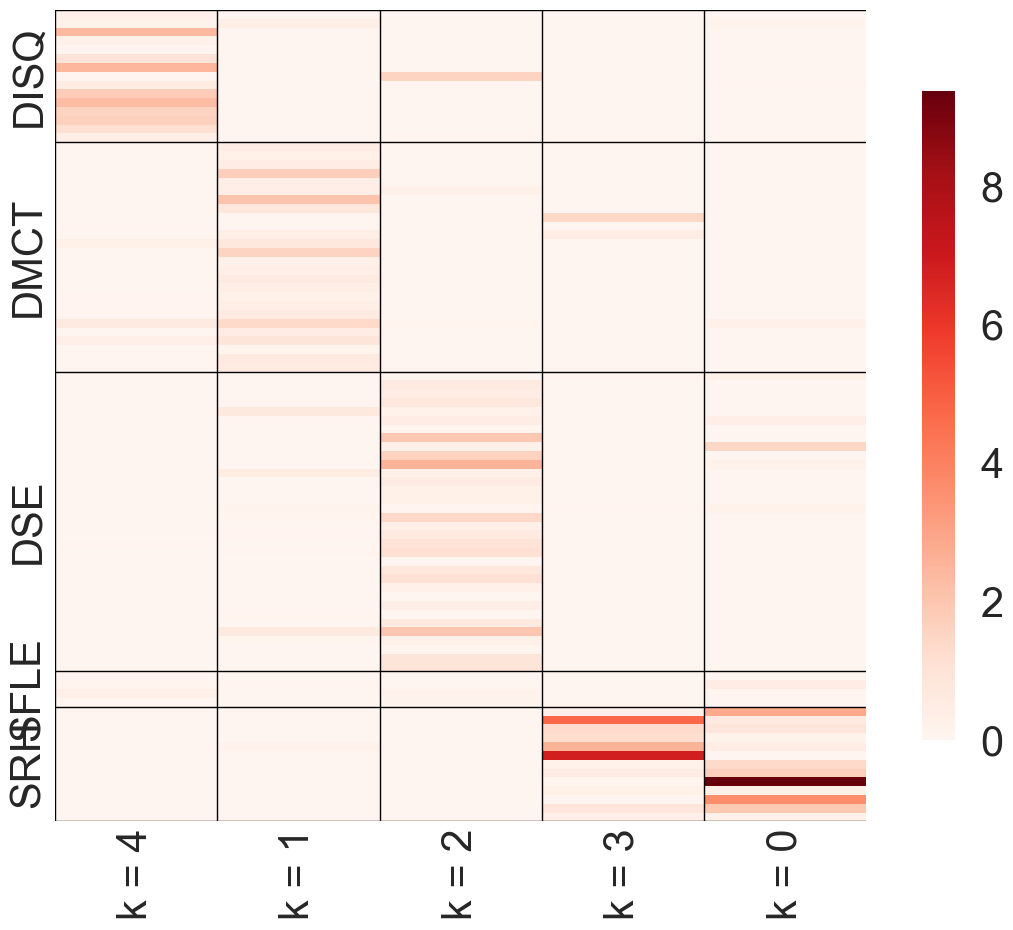

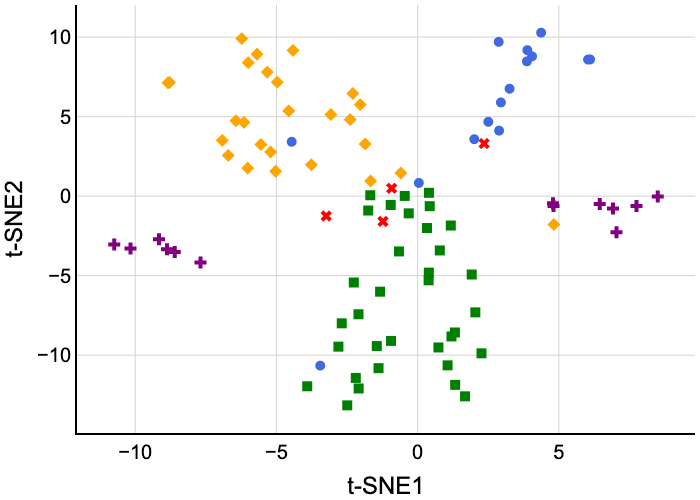

array([[ 2.00398088e+00,  3.58003139e+00],
       [-4.46144581e+00,  3.41750717e+00],
       [ 2.86959100e+00,  9.69993114e+00],
       [ 2.88310218e+00,  4.11749697e+00],
       [ 4.20446619e-02,  8.30439270e-01],
       [ 3.25518537e+00,  6.75317144e+00],
       [ 4.37162352e+00,  1.02785511e+01],
       [-3.44871521e+00, -1.06567450e+01],
       [ 2.94817281e+00,  5.88911724e+00],
       [ 6.03292751e+00,  8.58853054e+00],
       [ 6.10644150e+00,  8.59519577e+00],
       [ 4.05075407e+00,  8.78951073e+00],
       [ 3.88543224e+00,  9.17688084e+00],
       [ 3.86927295e+00,  8.47187138e+00],
       [ 2.50181389e+00,  4.67199373e+00],
       [-4.97344303e+00,  7.16455650e+00],
       [-2.38996029e+00,  4.80707741e+00],
       [-6.15092707e+00,  4.63408279e+00],
       [-8.78506374e+00,  7.15391874e+00],
       [-1.85959983e+00,  3.28342772e+00],
       [-4.56399441e+00,  5.35484457e+00],
       [-8.84177780e+00,  7.12491751e+00],
       [-5.32619572e+00,  7.79200697e+00],
       [ 4.

In [10]:
# Hy-MMSBM
model_name = "hymmsbm"
K = 5
model = hymmsbm.HyMMSBM(G, K, random_state=random_state)
best_loglik, (U, W) = model.fit()
community_order = [4,1,2,3,0]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red='t-SNE')

Numbers of steps [47, 64, 39, 57, 43, 36, 30, 49, 45, 46]


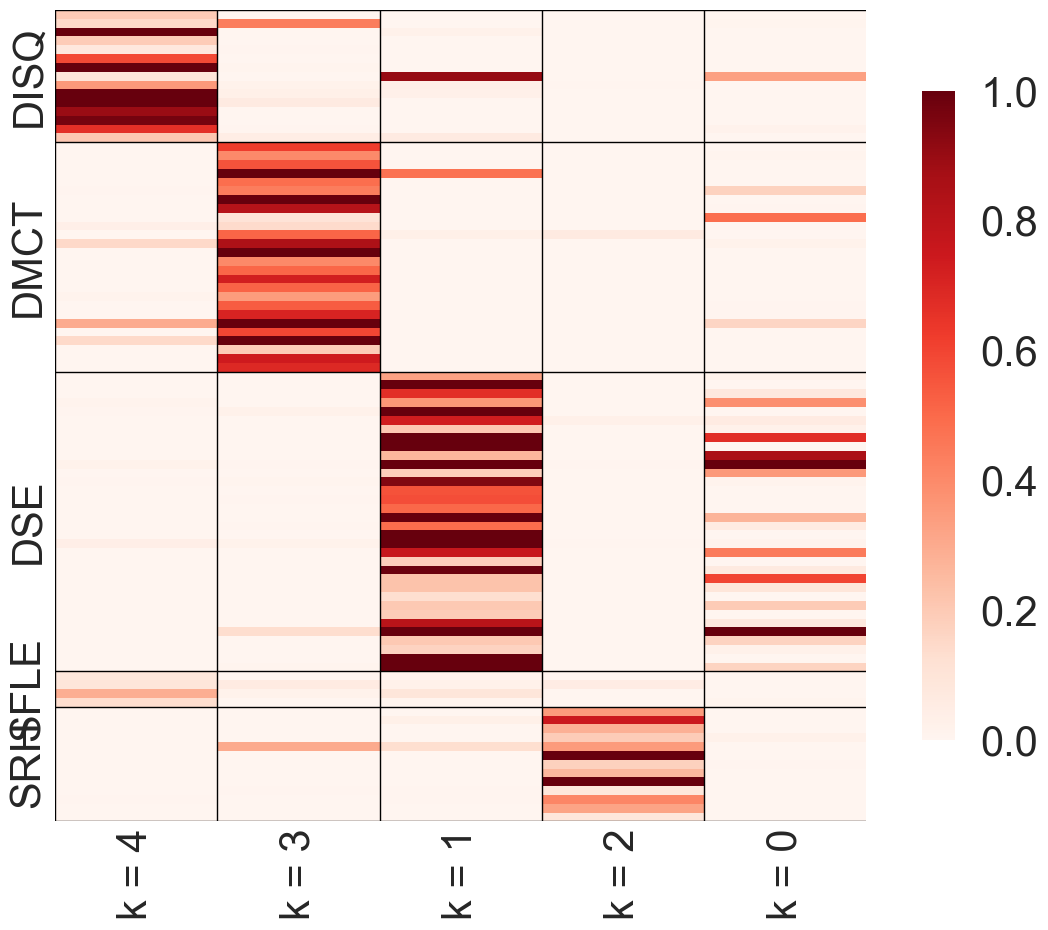

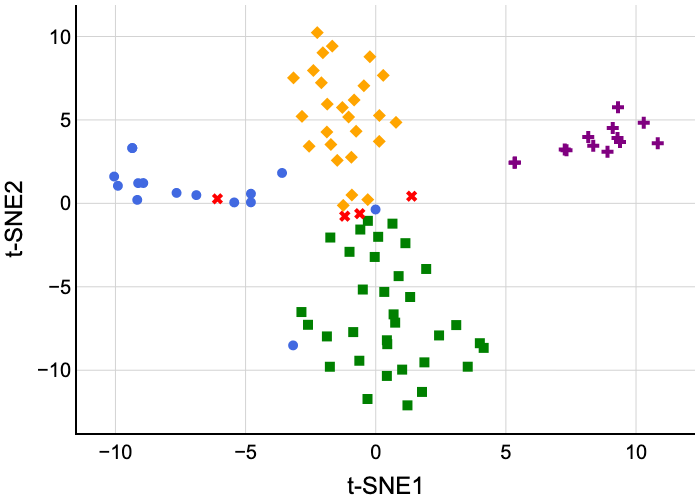

array([[-5.4365010e+00,  5.5610131e-02],
       [-3.5988190e+00,  1.8230066e+00],
       [-1.0049606e+01,  1.6077821e+00],
       [-4.7944689e+00,  5.7696354e-01],
       [-6.5660439e-03, -3.6652574e-01],
       [-7.6518855e+00,  6.2724119e-01],
       [-9.1612024e+00,  2.0962547e-01],
       [-3.1745059e+00, -8.5112982e+00],
       [-6.8915901e+00,  4.9417689e-01],
       [-9.3519745e+00,  3.3175561e+00],
       [-9.3530989e+00,  3.3098626e+00],
       [-8.9303761e+00,  1.2178802e+00],
       [-9.9054327e+00,  1.0528021e+00],
       [-9.1264343e+00,  1.2134960e+00],
       [-4.7956386e+00,  6.2242381e-02],
       [-2.0864675e+00,  7.2293339e+00],
       [-1.7220603e+00,  3.5319827e+00],
       [-1.2825319e+00,  5.7453585e+00],
       [-2.2390406e-01,  8.7879782e+00],
       [-9.3535191e-01,  2.7607059e+00],
       [-1.8611389e+00,  5.9444833e+00],
       [ 2.8824833e-01,  7.6686745e+00],
       [-2.3943498e+00,  7.9592195e+00],
       [-3.1065547e-01,  2.2338840e-01],
       [-1.24542

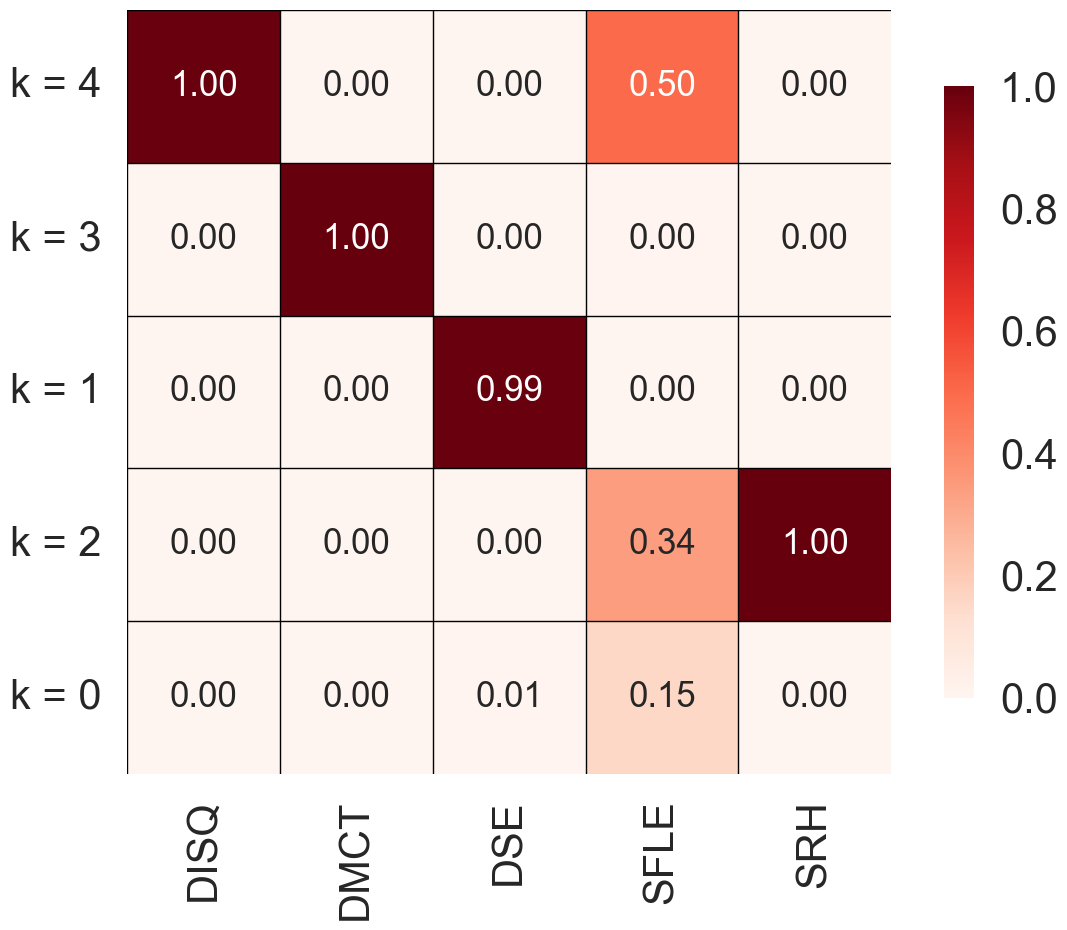

In [11]:
# HyCoSBM
model_name = "hycosbm"
K, gamma = 5, 0.9
model = hycosbm.HyCoSBM(G, K, gamma, random_state=random_state)
best_loglik, (U, W, beta) = model.fit()
community_order = [4,3,1,2,0]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
comm_vis.plot_inferred_attribute_correlation_matrix(data_name, beta, label_name, label_order, community_order, model_name)
comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red='t-SNE')

In [3]:
data_name = "hospital"
G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

Number of nodes: 75
Number of hyperedges: 1825
Sum of hyperedge weights: 27835
Average degree of the node: 59.053333333333335
Average size of the hyperedge: 2.4268493150684933
Maximum size of the hyperedge: 5
Hyperedge size distribution: {2: 1108, 3: 657, 4: 58, 5: 2}
Number of distinct node lables: 4
Number of nodes by attribute: {0: 12, 1: 6, 2: 33, 3: 24}
Connected hypergraph: True



In [ ]:
hymmsbm_auc_score = hymmsbm_hyperparameter_tuning(G)

In [ ]:
hycosbm_auc_score = hycosbm_hyperparamter_tuning(G)

In [ ]:
hymmsbm_best_param = 2
hycosbm_best_param = (2, 0.3)
#print(stats.ttest_ind(list(hymmsbm_auc_score[hymmsbm_best_param]), hycosbm_auc_score[hycosbm_best_param], equal_var=False, alternative='less'))

In [ ]:
signed_rank_test(G, hymmsbm_best_param, hycosbm_best_param, num_samples=100)

In [4]:
label_name = ["ADM","MED","NUR","PAT"]
label_order = [0,1,2,3]

Numbers of steps [3, 18, 12, 3, 15, 3, 13, 12, 21, 15]


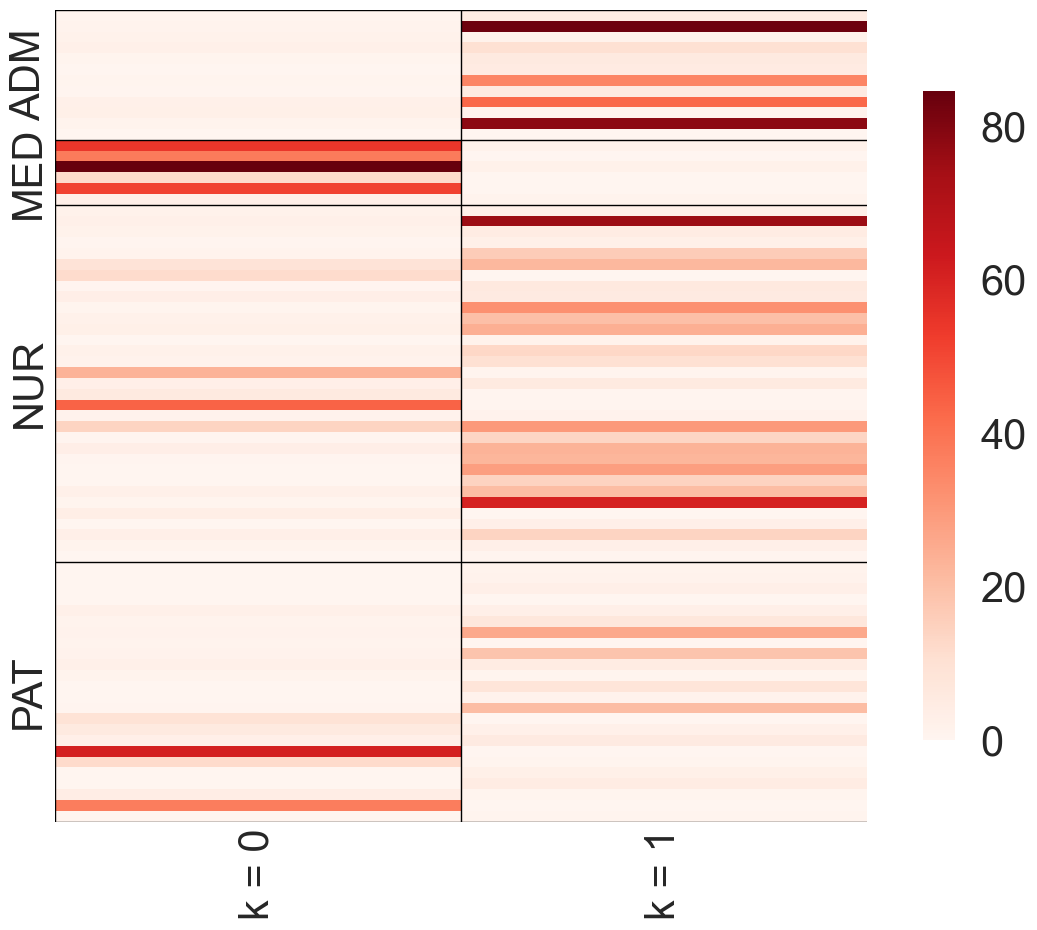

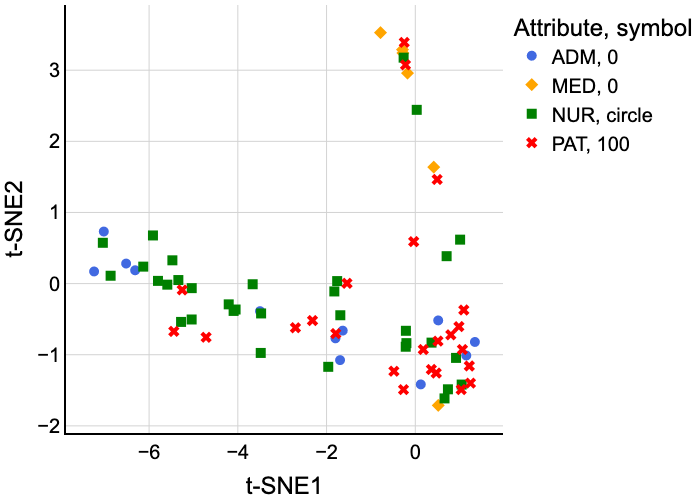

array([[-1.6357127e+00, -6.6136473e-01],
       [-7.2392988e+00,  1.7055255e-01],
       [ 1.2380313e-01, -1.4170047e+00],
       [-3.4994488e+00, -3.8730088e-01],
       [-1.6956387e+00, -1.0756003e+00],
       [-1.7993451e+00, -7.6953489e-01],
       [-6.3144898e+00,  1.8719375e-01],
       [ 1.3433501e+00, -8.2039201e-01],
       [-6.5175748e+00,  2.8178099e-01],
       [ 5.1652324e-01, -5.1758409e-01],
       [-7.0205593e+00,  7.3159850e-01],
       [ 1.1495360e+00, -1.0112185e+00],
       [-2.8992411e-01,  3.2889380e+00],
       [-1.7466000e-01,  2.9584925e+00],
       [-7.8524661e-01,  3.5277102e+00],
       [ 4.1606903e-01,  1.6375561e+00],
       [-2.8063706e-01,  3.2417960e+00],
       [ 5.1852334e-01, -1.7115506e+00],
       [-2.1175876e-01, -6.6343373e-01],
       [-7.0423446e+00,  5.7360184e-01],
       [-1.6898017e+00, -4.4496059e-01],
       [-2.1540804e-01, -8.8748765e-01],
       [-3.6652713e+00, -9.1429912e-03],
       [-5.4747224e+00,  3.2718858e-01],
       [ 1.04536

In [5]:
# Hy-MMSBM
model_name = "hymmsbm"
K = 2
model = hymmsbm.HyMMSBM(G, K, random_state=random_state)
best_loglik, (U, W) = model.fit()
community_order = [0, 1]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red='t-SNE')
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "cosine", model_name)

Numbers of steps [12, 26, 17, 12, 13, 12, 26, 25, 32, 26]


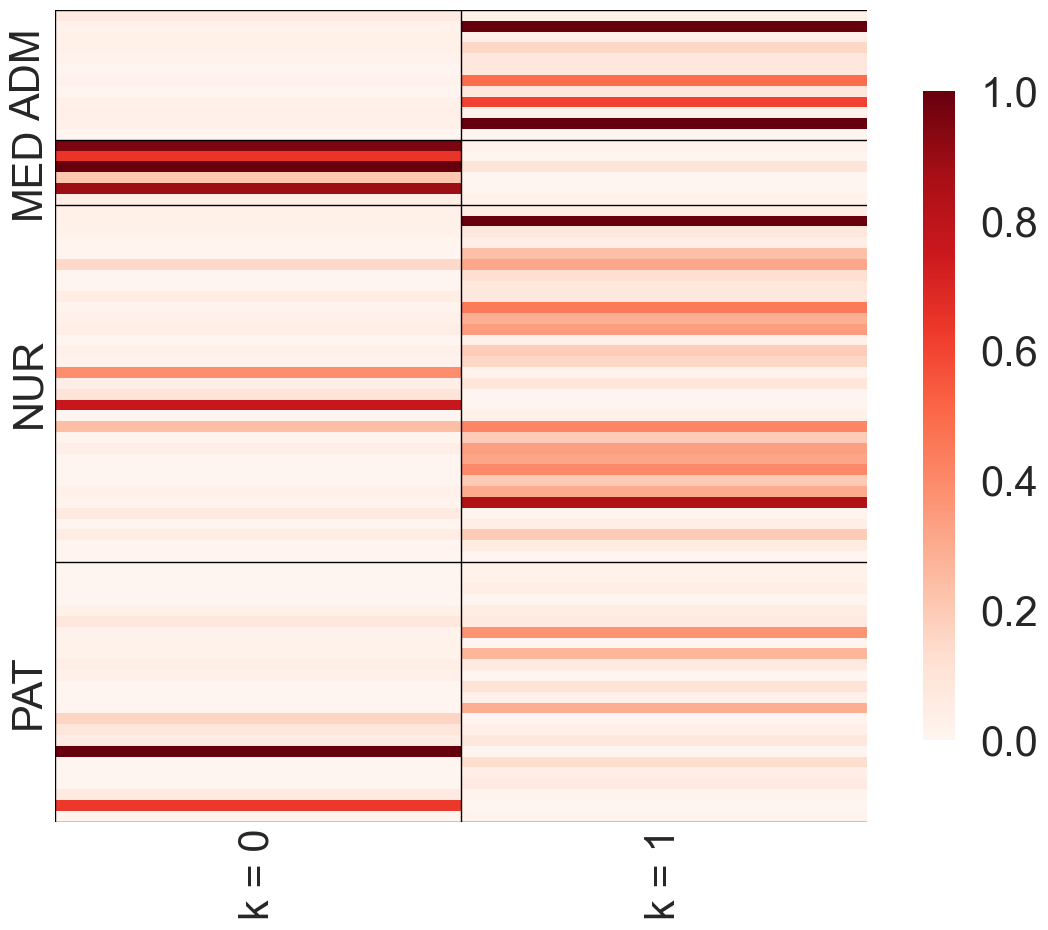

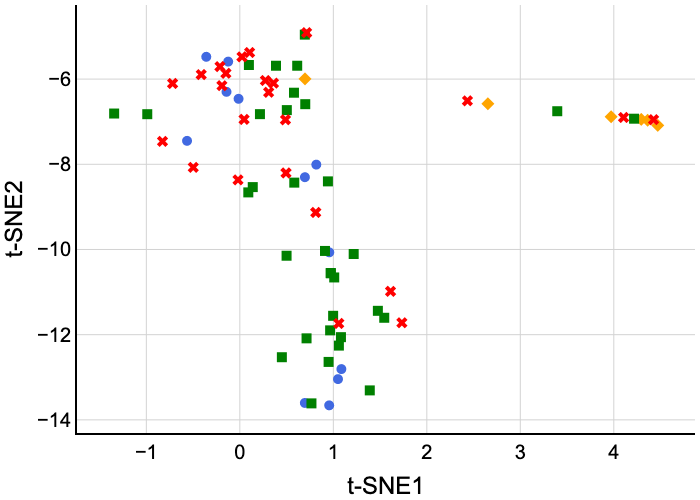

array([[-5.64510584e-01, -7.44969606e+00],
       [ 9.55771983e-01, -1.36591110e+01],
       [-1.34250391e-02, -6.46265078e+00],
       [ 9.56931412e-01, -1.00672865e+01],
       [ 8.17953944e-01, -8.00757599e+00],
       [ 6.96008623e-01, -8.30278683e+00],
       [ 1.08599126e+00, -1.28077173e+01],
       [-3.58880371e-01, -5.47661495e+00],
       [ 1.05002809e+00, -1.30430708e+01],
       [-1.42617583e-01, -6.29867458e+00],
       [ 6.95471466e-01, -1.36026974e+01],
       [-1.24471352e-01, -5.58912516e+00],
       [ 4.36221409e+00, -6.96512270e+00],
       [ 3.97120094e+00, -6.88271523e+00],
       [ 4.47107267e+00, -7.08609056e+00],
       [ 2.65197158e+00, -6.57872248e+00],
       [ 4.29312420e+00, -6.94596291e+00],
       [ 6.97071254e-01, -5.99194098e+00],
       [ 2.15194449e-01, -6.82249975e+00],
       [ 7.66000450e-01, -1.36128531e+01],
       [ 5.82519412e-01, -8.43051720e+00],
       [ 5.02518833e-01, -6.72804213e+00],
       [ 1.21779573e+00, -1.01055851e+01],
       [ 7.

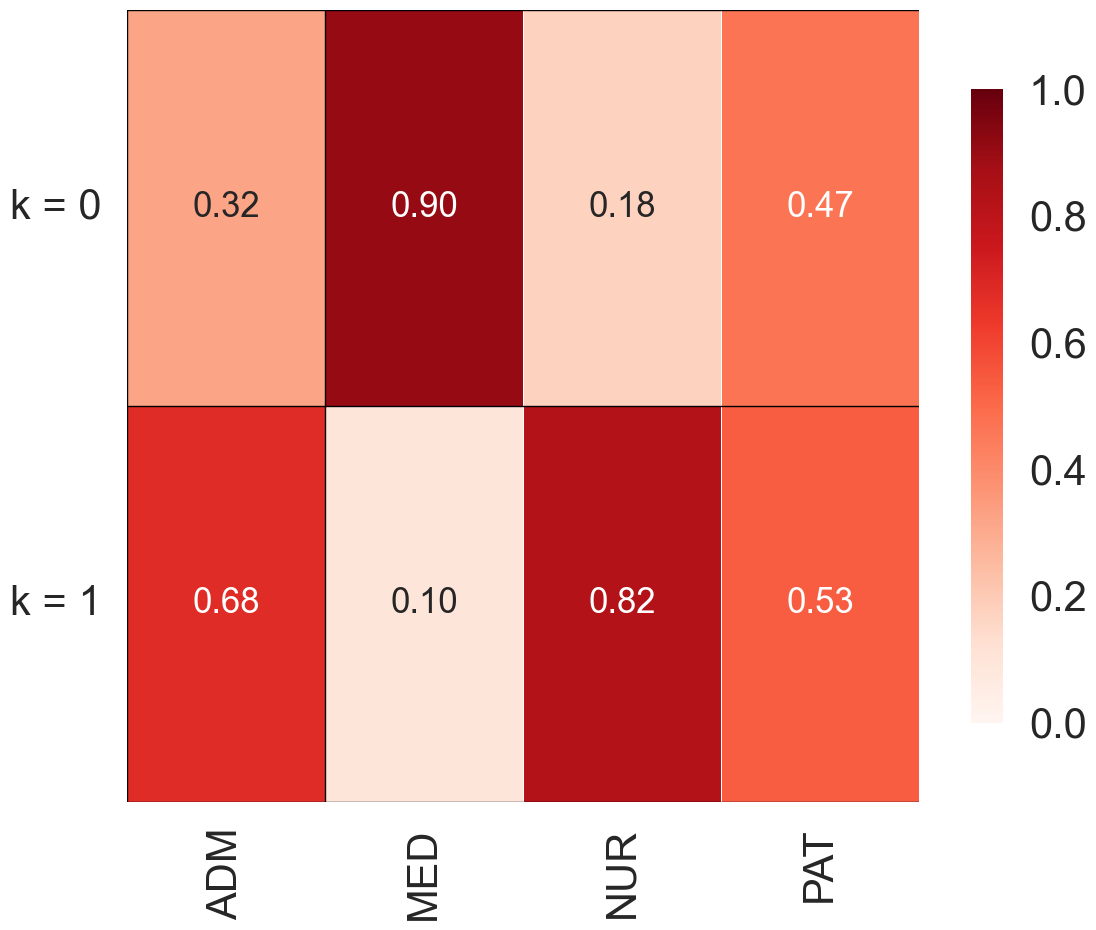

In [6]:
# HyCoSBM
model_name = "hycosbm"
K, gamma = 2, 0.7
model = hycosbm.HyCoSBM(G, K, gamma, random_state=random_state)
best_loglik, (U, W, beta) = model.fit()
community_order = [0, 1]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
comm_vis.plot_inferred_attribute_correlation_matrix(data_name, beta, label_name, label_order, community_order, model_name)
comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red='t-SNE')
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "cosine", model_name)

In [6]:
data_name = "contact-high-school"
G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

Number of nodes: 327
Number of hyperedges: 7818
Sum of hyperedge weights: 7818
Average degree of the node: 55.63302752293578
Average size of the hyperedge: 2.3269378357636223
Maximum size of the hyperedge: 5
Hyperedge size distribution: {3: 2091, 4: 222, 2: 5498, 5: 7}
Number of distinct node lables: 9
Number of nodes by attribute: {8: 33, 2: 40, 7: 39, 6: 44, 0: 36, 3: 29, 1: 34, 5: 34, 4: 38}
Connected hypergraph: True



In [ ]:
hymmsbm_auc_score = hymmsbm_hyperparameter_tuning(G)

In [ ]:
hycosbm_auc_score = hycosbm_hyperparamter_tuning(G)

In [ ]:
hymmsbm_best_param = 3
hycosbm_best_param = (9, 0.9)
#print(stats.ttest_ind(list(hymmsbm_auc_score[hymmsbm_best_param]), hycosbm_auc_score[hycosbm_best_param], equal_var=False, alternative='less'))

In [ ]:
signed_rank_test(G, hymmsbm_best_param, hycosbm_best_param, num_samples=100)

In [7]:
label_name = ["2BIO1", "2BIO2", "2BIO3", "MP*1", "MP*2", "PSI*", "PC", "PC*", "MP"]
label_order = [0, 1, 2, 8, 3, 4, 6, 7, 5]

Numbers of steps [3, 3, 17, 18, 3, 3, 3, 3, 3, 3]


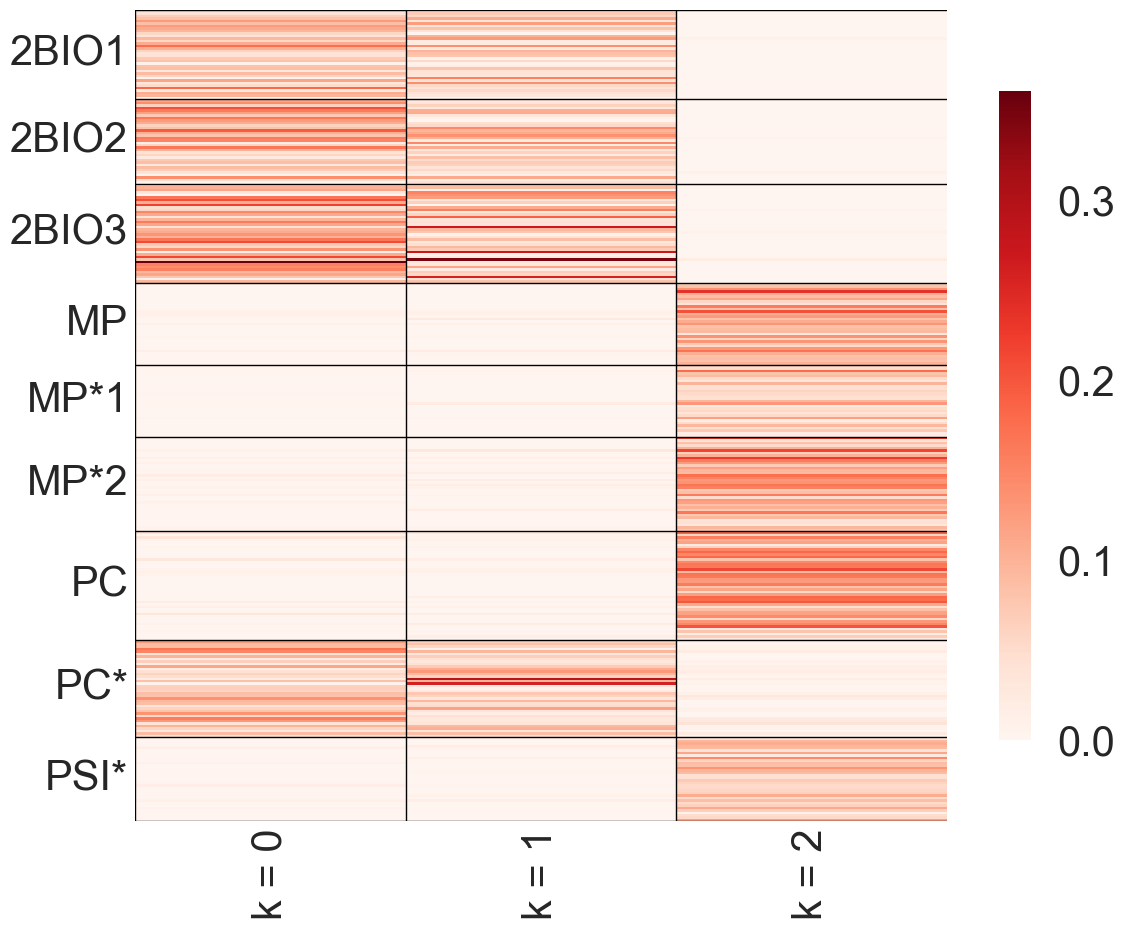

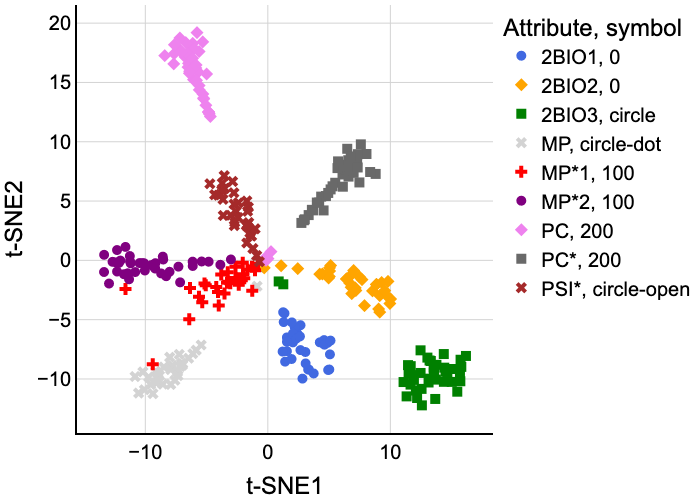

array([[-6.46296978e+00, -8.25371933e+00],
       [-7.13214731e+00, -8.94732857e+00],
       [ 1.26206267e+00, -2.01869464e+00],
       [ 1.35476456e+01, -9.46409512e+00],
       [ 7.28495407e+00,  8.40532398e+00],
       [ 6.99893332e+00,  7.37891006e+00],
       [ 1.33021679e+01, -8.48315907e+00],
       [ 1.16478300e+01, -1.04755850e+01],
       [-8.41486549e+00,  1.72690926e+01],
       [-4.84293747e+00,  1.25216951e+01],
       [-7.26881599e+00,  1.78501301e+01],
       [ 6.09494209e+00,  7.23862982e+00],
       [ 8.80094433e+00,  7.28832102e+00],
       [ 2.66655421e+00, -5.46680069e+00],
       [ 2.40631342e+00, -6.17395401e+00],
       [ 1.10785389e+01, -1.02596178e+01],
       [ 1.54629803e+01, -1.10725937e+01],
       [ 7.59027529e+00,  9.78041553e+00],
       [ 3.33242345e+00,  3.81773853e+00],
       [ 6.33382368e+00,  7.63399744e+00],
       [-9.55948734e+00, -1.04638815e+01],
       [-1.05472383e+01, -1.11885366e+01],
       [-3.52876353e+00, -2.78767109e+00],
       [-3.

In [8]:
# Hy-MMSBM
model_name = "hymmsbm"
K = 3
model = hymmsbm.HyMMSBM(G, K, random_state=random_state)
best_loglik, (U, W) = model.fit()
community_order = [0, 1, 2]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red='t-SNE')
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "cosine", model_name, dim_red='t-SNE')

Numbers of steps [40, 42, 41, 74, 47, 51, 38, 43, 57, 40]


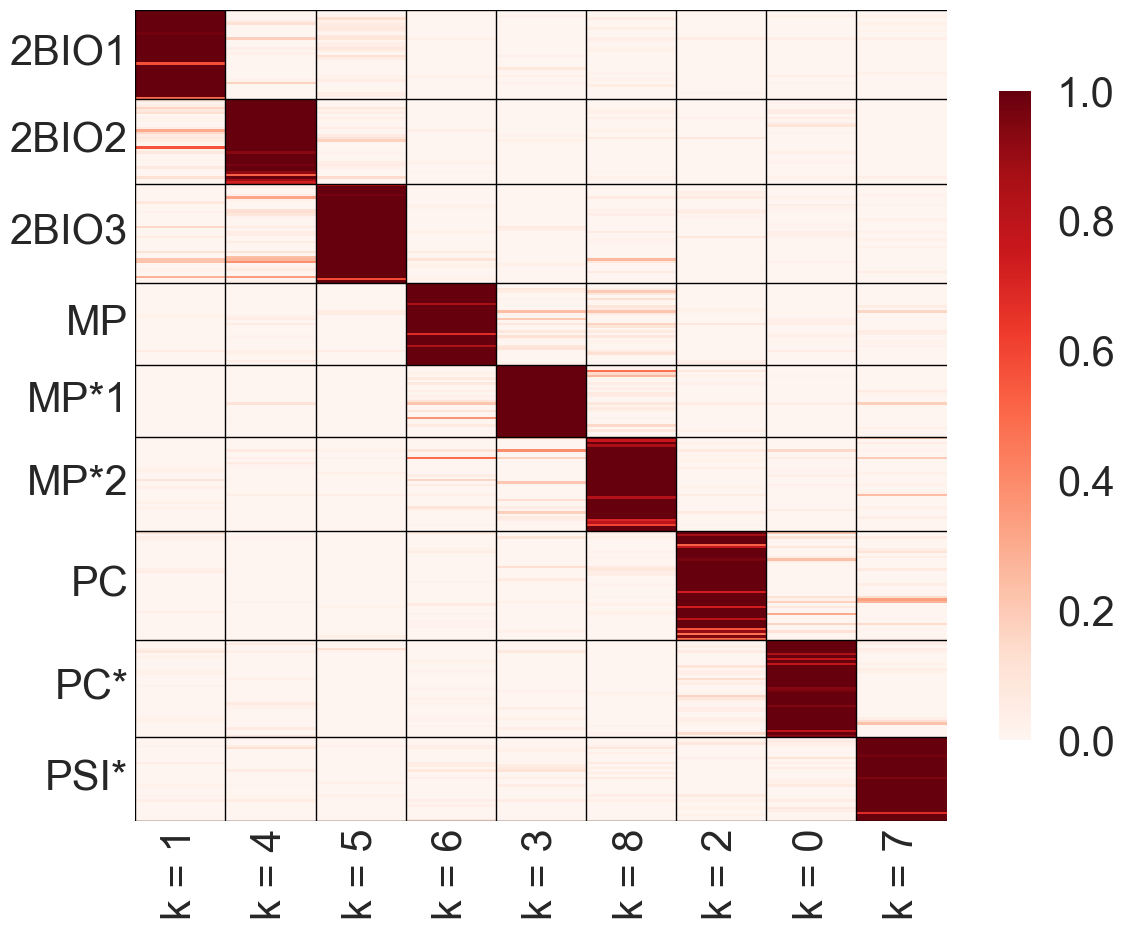

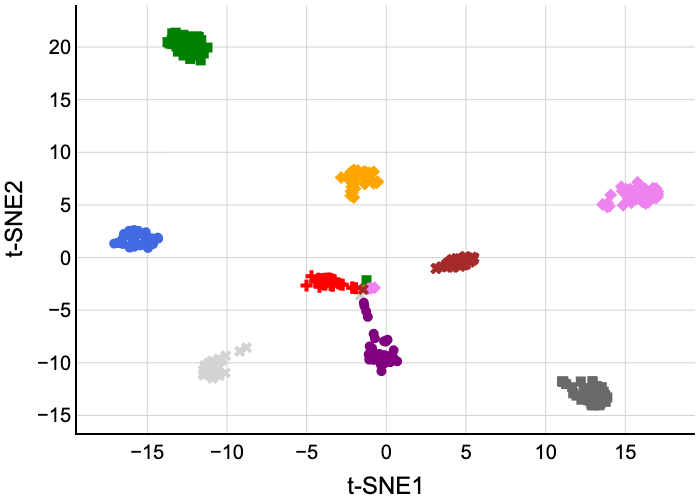

array([[-1.05103769e+01, -9.62763119e+00],
       [-1.08056431e+01, -1.03849287e+01],
       [-1.16467009e+01,  1.87322979e+01],
       [-1.16425381e+01,  2.02058849e+01],
       [ 1.36464548e+01, -1.27390347e+01],
       [ 1.35707884e+01, -1.33261547e+01],
       [-1.21379080e+01,  1.91718330e+01],
       [-1.18113260e+01,  1.94003506e+01],
       [ 1.60591755e+01,  6.53423452e+00],
       [ 1.40917368e+01,  5.95727301e+00],
       [ 1.57547836e+01,  6.36332846e+00],
       [ 1.22414627e+01, -1.35073576e+01],
       [ 1.36344690e+01, -1.30227108e+01],
       [-1.70795670e+01,  1.32798600e+00],
       [-1.65579014e+01,  1.69898534e+00],
       [-1.34319439e+01,  2.13082542e+01],
       [-1.29440165e+01,  2.10285435e+01],
       [ 1.28959026e+01, -1.40402794e+01],
       [ 1.22087278e+01, -1.17706680e+01],
       [ 1.28525448e+01, -1.34286194e+01],
       [-1.11949987e+01, -1.02949047e+01],
       [-1.14961538e+01, -1.11162357e+01],
       [-3.84423852e+00, -2.01697397e+00],
       [-3.

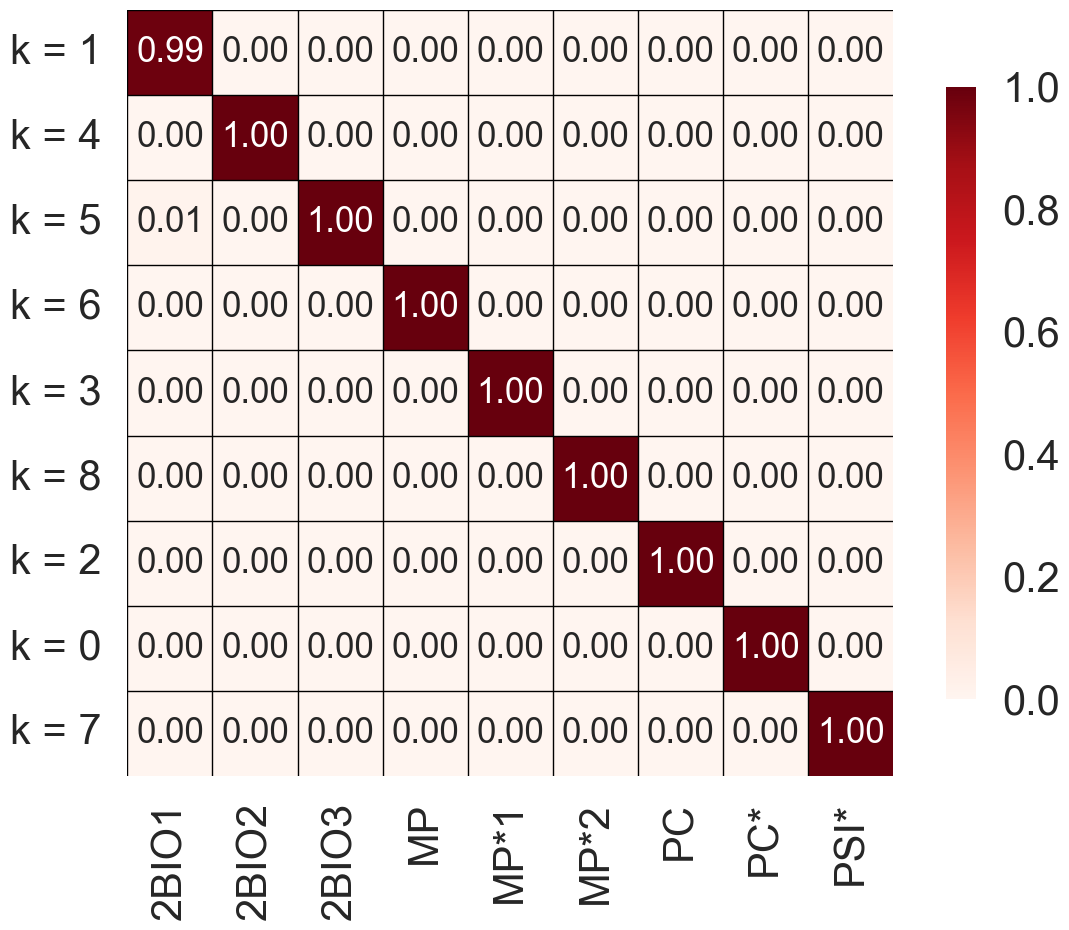

In [10]:
# HyCoSBM
model_name = "hycosbm"
K, gamma = 9, 0.9
model = hycosbm.HyCoSBM(G, K, gamma, random_state=random_state)
best_loglik, (U, W, beta) = model.fit()
community_order = [1,4,5,6,3,8,2,0,7]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
comm_vis.plot_inferred_attribute_correlation_matrix(data_name, beta, label_name, label_order, community_order, model_name)
comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name, dim_red='t-SNE')
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "cosine", model_name, dim_red='t-SNE')

In [ ]:
data_name = "contact-primary-school"
G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

In [ ]:
hymmsbm_auc_score = hymmsbm_hyperparameter_tuning(G)

In [ ]:
hycosbm_auc_score = hycosbm_hyperparamter_tuning(G)

In [ ]:
hymmsbm_best_param = 3
hycosbm_best_param = (11, 0.8)
#print(stats.ttest_ind(list(hymmsbm_auc_score[hymmsbm_best_param]), hycosbm_auc_score[hycosbm_best_param], equal_var=False, alternative='less'))
signed_rank_test(G, hymmsbm_best_param, hycosbm_best_param, num_samples=100)

In [ ]:
label_name = ["5B", "5A", "4A", "Teachers", "3B", "4B", "2A", "1B", "2B", "1A", "3A"]
label_order = [9, 7, 6, 8, 10, 4, 2, 5, 1, 0, 3]

In [ ]:
# Hy-MMSBM
model_name = "hymmsbm"
K = 3
model = hymmsbm.HyMMSBM(G, K, random_state=random_state)
best_loglik, (U, W) = model.fit()
community_order = [0, 2, 1]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name)
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "cosine", model_name)

In [ ]:
# HyCoSBM
model_name = "hycosbm"
K, gamma = 11, 0.8
model = hycosbm.HyCoSBM(G, K, gamma, random_state=random_state)
best_loglik, (U, W, beta) = model.fit()
community_order = [9,0,3,4,8,6,10,1,2,7,5]
comm_vis.plot_inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order, model_name)
comm_vis.plot_inferred_attribute_correlation_matrix(data_name, beta, label_name, label_order, community_order, model_name)
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "euclidean", model_name)
#comm_vis.node_embedding(G, data_name, U, W, label_name, label_order, random_state, "cosine", model_name)

In [ ]:
data_name = "house-committees"
G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

In [ ]:
hymmsbm_auc_score = hymmsbm_hyperparameter_tuning(G)

In [ ]:
hycosbm_auc_score = hycosbm_hyperparamter_tuning(G)

In [ ]:
hymmsbm_best_param = 15
hycosbm_best_param = (4, 0.4)
#print(stats.ttest_ind(list(hymmsbm_auc_score[hymmsbm_best_param]), hycosbm_auc_score[hycosbm_best_param], equal_var=False, alternative='less'))
signed_rank_test(G, hymmsbm_best_param, hycosbm_best_param, num_samples=100)

In [ ]:
data_name = "senate-committees"
G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

In [ ]:
hymmsbm_auc_score = hymmsbm_hyperparameter_tuning(G)

In [ ]:
hycosbm_auc_score = hycosbm_hyperparamter_tuning(G)

In [ ]:
hymmsbm_best_param = 3
hycosbm_best_param = (4, 0.7)
#print(stats.ttest_ind(list(hymmsbm_auc_score[hymmsbm_best_param]), hycosbm_auc_score[hycosbm_best_param], equal_var=False, alternative='less'))
signed_rank_test(G, hymmsbm_best_param, hycosbm_best_param, num_samples=100)